# Handling Imbalanced Datasets in Machine Learning

The work conducted in this notebook is taken from this [article](https://towardsdatascience.com/handling-imbalanced-datasets-in-machine-learning-7a0e84220f28) and is repeated here for my own understanding.

Accuracy is not always a good metric to evaluate models on with an imbalanced dataset as the classifier will always predict the majority class and thus have a high accuracy. Evaluating the model with a confusion matrix will highlight the issue of the model not predicting the minority class. This notebook highlights the issues with imbalanced datasets and some of the solutions possible along with their limitations.

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pylab as p
from scipy import signal, stats
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight

In [2]:
np.random.seed(42)

## What is really the Problem?

To understand this let's first create a dataset with a total of 50 points. This dataset contains two classes $C_0$ which has 45 points and $C_1$ which has 5 points. As a result 90% of the data belongs to class $C_0$. The datasets are generated by sampling from a normal distribution which the following parameters:
- **$C_0$**: $\mu=0$, $\sigma=2$
- **$C_1$**: $\mu=2$, $\sigma=1$

In [3]:
n_c0 = 45
n_c1 = 5
n_points = 50
c0 = np.random.normal(0, np.sqrt(4), n_c0)
c1 = np.random.normal(2, np.sqrt(1), n_c1)

Plotting the distributions below:

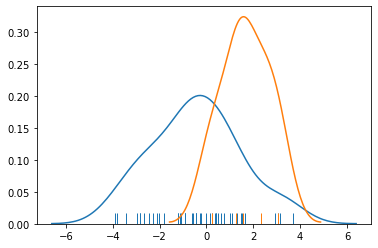

In [4]:
sns.distplot(c0, hist=False, rug=True)
sns.distplot(c1, hist=False, rug=True)

We have two distributions which overlap. I'm going to cheat slightly and give us smooth normal distributions by fitting Gaussians to the distributions above:

In [5]:
mu0, std0 = stats.norm.fit(c0)
mu1, std1 = stats.norm.fit(c1)

Plotting the fitted gaussians:

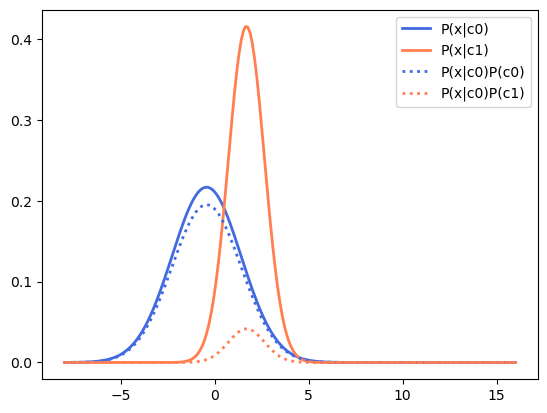

In [6]:
mpl.style.use('default')
x = np.linspace(-8, 16, 200)
p0 = stats.norm.pdf(x, mu0, std0)
p1 = stats.norm.pdf(x, mu1, std1)
p0_proportional = p0 * (n_c0 / n_points)
p1_proportional = p1 * (n_c1 / n_points)
plt.plot(x, p0, 'k', linewidth=2, color='royalblue', label='P(x|c0)')
plt.plot(x, p1, 'k', linewidth=2, color='coral', label='P(x|c1)')
plt.plot(x, p0_proportional, 'k', linewidth=2, color='royalblue', linestyle=':', label='P(x|c0)P(c0)')
plt.plot(x, p1_proportional, 'k', linewidth=2, color='coral', linestyle=':', label='P(x|c0)P(c1)')
plt.legend()
plt.show()

The plot above illustrates our dataset in two ways. The solid lines represent the distributions of the two classes independently where are the dotted lines show the classes proportionally to each other. The plots are calculated as follows:
- $C_0$ = $P(x|C_0)$ = 1
- $C_1$ = $P(x|C_1)$ = 1
- $C_0$ proportional = $P(x|C_0)P(C_0)$ = $1 \times 0.9$
- $C_1$ proportional = $P(x|C_1)P(C_1)$ = $1 \times 0.1$

As a result the proportional representation of $C_0$ is 90% of $C_0$ independently and $C_1$ is 10% of $C_1$ represented independently. When the classes are represented proportionally we can see that $C_0$ is always above the curve of $C_1$. This means for any given point the probability that this point is drawn from $C_0$ is always greater than the probability it was drawn from $C_1$. We can write this mathematically using Bayes rule:

\begin{equation*}
P(C_0|x) = \frac{P(x|C_0)P(C_0)}{P(x)} > \frac{P(x|C_1)P(C_1)}{P(x)} = P(C_1|x)
\end{equation*}

It is clear to see how the class priors lead to a situation where a class is always more likely than the other.

So what does this mean? From a theoretical point of view we know that had we trained a classifier on this dataset, the **accuracy of the classifier would be maximal when always answering $C_0$**. If the goal of this project was to build a classifier which was optimised for accuracy this would not be a problem. From a practical point of view with these features the best a model can do (in terms of accuracy) is to always answer $C_0$. There is nothing we can do but accept it.

## It's all about Separability

The example above shows the classes are not well separated. Not all imbalanced datasets have classes that are not well separated, in this case a classifier should do a good job at predicting the minority class. For example, below I've repeated the plot above but move the centre of the minority class to a $\mu=8$:

In [7]:
c1_separated = np.random.normal(8, np.sqrt(1), n_c1)
mu1_separated, std1_separated = stats.norm.fit(c1_separated)

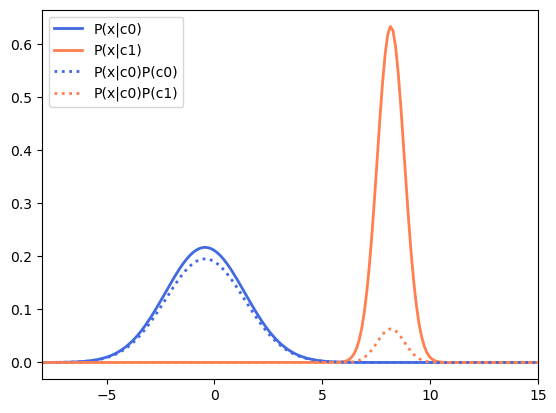

In [8]:
p0 = stats.norm.pdf(x, mu0, std0)
p1_separated = stats.norm.pdf(x, mu1_separated, std1_separated)
p0_proportional = p0 * (n_c0 / n_points)
p1_proportional_separated = p1_separated * (n_c1 / n_points)
plt.plot(x, p0, 'k', linewidth=2, color='royalblue', label='P(x|c0)')
plt.plot(x, p1_separated, 'k', linewidth=2, color='coral', label='P(x|c1)')
plt.plot(x, p0_proportional, 'k', linewidth=2, color='royalblue', linestyle=':', label='P(x|c0)P(c0)')
plt.plot(x, p1_proportional_separated, 'k', linewidth=2, color='coral', linestyle=':', label='P(x|c0)P(c1)')
plt.xlim((-8, 15))
plt.legend()
plt.show()

This case is very different to the initial case.  The curve of $C_0$ is not above that of $C_1$ meaning that there a points more likely to be drawn from $C_1$ that from $C_0$. In this case the classes are separated well enough to compensate for the imbalance and a classifier will not always answer $C_0$.

## Theoretical minimal error probability

All classifiers have a theoretical minimal error probability. For a classifier of this kind (one feature, two classes), we can mention that, graphically, the theoretical minimal error probability is given by the area under the minimum of the two curves:

In [9]:
c1_partly_separated = np.random.normal(4, np.sqrt(1), n_c1)
mu1_partly_separated, std1_partly_separated = stats.norm.fit(c1_partly_separated)

c1_separated = np.random.normal(8, np.sqrt(1), n_c1)
mu1_separated, std1_separated = stats.norm.fit(c1_separated)

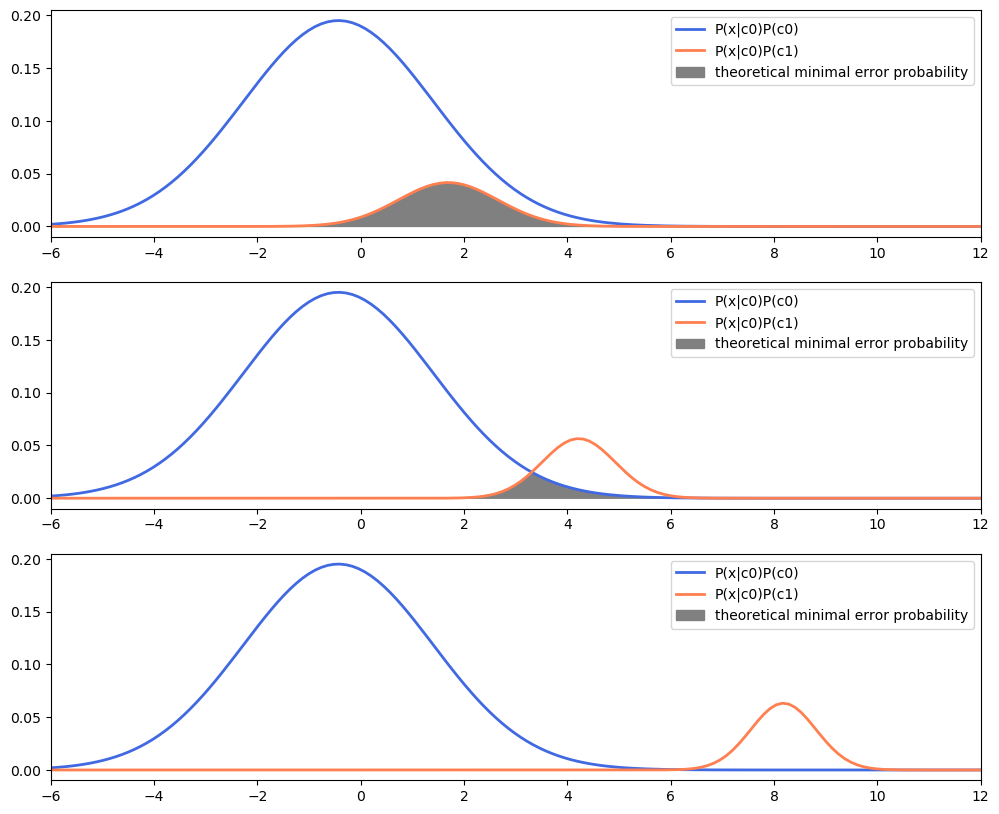

In [10]:
fig, axs = plt.subplots(3, figsize=((12,10)))

axs[0].plot(x, p0_proportional, 'k', linewidth=2, color='royalblue', label='P(x|c0)P(c0)')
axs[0].plot(x, p1_proportional, 'k', linewidth=2, color='coral', label='P(x|c0)P(c1)')
axs[0].fill_between(x, np.minimum(p0_proportional, p1_proportional), color='grey', label='theoretical minimal error probability')
axs[0].set_xlim([-6, 12])
axs[0].legend()


p1_partly_separated = stats.norm.pdf(x, mu1_partly_separated, std1_partly_separated)
p1_proportional_partly_separated = p1_partly_separated * (n_c1 / n_points)
axs[1].plot(x, p0_proportional, 'k', linewidth=2, color='royalblue', label='P(x|c0)P(c0)')
axs[1].plot(x, p1_proportional_partly_separated, 'k', linewidth=2, color='coral', label='P(x|c0)P(c1)')
axs[1].fill_between(x, np.minimum(p0_proportional, p1_proportional_partly_separated), color='grey', label='theoretical minimal error probability')
axs[1].set_xlim([-6, 12])
axs[1].legend()

axs[2].plot(x, p0_proportional, 'k', linewidth=2, color='royalblue', label='P(x|c0)P(c0)')
axs[2].plot(x, p1_proportional_separated, 'k', linewidth=2, color='coral', label='P(x|c0)P(c1)')
axs[2].fill_between(x, np.minimum(p0_proportional, p1_proportional_separated), color='grey', label='theoretical minimal error probability')
axs[2].set_xlim([-6, 12])
axs[2].legend()

From a theoretical perspective the best possible classifier will always for a given point select the most probable class. This implies that for a given point x, the best theoretical error probability is given by the less likely of these two classes. The grey areas in the plot above represent the theoretical minimal error probability.

## Re-working the dataset is not always a solution

If we have an imbalanced dataset but we believe the dataset is balanced in reality then we have proportion bias and more data should be collected to obtain a representative example.

In most cases it won't be possible to obtain additional data and we have to work with what we have. The next two sub-sections present some methods in dealing with imbalanced classes that deal with the data we currently have. More specifically, the risks related to undersampling, oversampling and generating synthetic data will be discussed.

### Undersampling, oversampling and generating synthetic data

These methods present great ways to balance the dataset before fitting a classifier on it. Briefly, they can be described as:

- **undersampling**: sampling the majority class in order to keep only a portion of these data points
- **oversampling**: replicating data points from the minority class in order to increase is cardinality
- **generating synthetic data**: create new synthetic data points from the minority class e.g. SMOTE to increase cardinality

These approaches aim to fully or partially balance the dataset. In reality should we really be balancing the datasets? Or should the majority class stay as the most represented? If so, how should we rebalance? The plots below illustrate the undersampling of the $C_0$ class by taking 90%, 50% and 30% of the original data points without replacement.

Creating an undersampled $C_0$ with 90%, 50% and 30% of the orginal data points.

In [11]:
under_90 = np.random.choice(c0, size=int(c0.shape[0] * 0.9), replace=False)
under_50 = np.random.choice(c0, size=int(c0.shape[0] * 0.5), replace=False)
under_30 = np.random.choice(c0, size=int(c0.shape[0] * 0.3), replace=False)

mu_under_90, std_under_90 = stats.norm.fit(under_90)
mu_under_50, std_under_50 = stats.norm.fit(under_50)
mu_under_30, std_under_30 = stats.norm.fit(under_30)

p_under_90 = stats.norm.pdf(x, mu_under_90, std_under_90)
p_under_50 = stats.norm.pdf(x, mu_under_50, std_under_50)
p_under_30 = stats.norm.pdf(x, mu_under_30, std_under_30)

Plotting these distributions

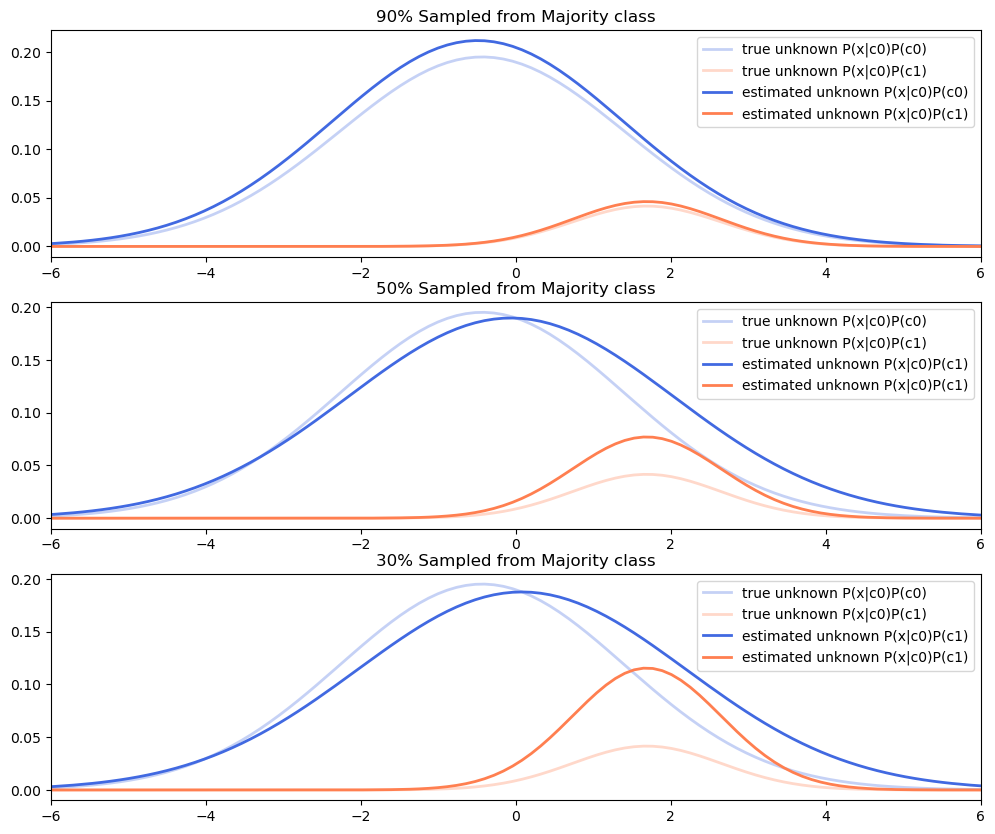

In [12]:
fig, axs = plt.subplots(3, figsize=((12,10)))

axs[0].plot(x, p0_proportional, 'k', linewidth=2, color='royalblue', alpha=0.3, label='true unknown P(x|c0)P(c0)')
axs[0].plot(x, p1_proportional, 'k', linewidth=2, color='coral', alpha=0.3, label='true unknown P(x|c0)P(c1)')
axs[0].plot(x, p_under_90, 'k', linewidth=2, color='royalblue', label='estimated unknown P(x|c0)P(c0)')
axs[0].plot(x, p1 * (c1.shape[0] / (under_90.shape[0] + c1.shape[0])), 'k', linewidth=2, color='coral', label='estimated unknown P(x|c0)P(c1)')
axs[0].set_title('90% Sampled from Majority class')
axs[0].set_xlim([-6, 6])
axs[0].legend()

axs[1].plot(x, p0_proportional, 'k', linewidth=2, color='royalblue', alpha=0.3, label='true unknown P(x|c0)P(c0)')
axs[1].plot(x, p1_proportional, 'k', linewidth=2, color='coral', alpha=0.3, label='true unknown P(x|c0)P(c1)')
axs[1].plot(x, p_under_50, 'k', linewidth=2, color='royalblue', label='estimated unknown P(x|c0)P(c1)')
axs[1].plot(x, p1 * (c1.shape[0] / (under_50.shape[0] + c1.shape[0])), 'k', linewidth=2, color='coral', label='estimated unknown P(x|c0)P(c1)')
axs[1].set_title('50% Sampled from Majority class')
axs[1].set_xlim([-6, 6])
axs[1].legend()

axs[2].plot(x, p0_proportional, 'k', linewidth=2, color='royalblue', alpha=0.3, label='true unknown P(x|c0)P(c0)')
axs[2].plot(x, p1_proportional, 'k', linewidth=2, color='coral', alpha=0.3, label='true unknown P(x|c0)P(c1)')
axs[2].plot(x, p_under_30, 'k', linewidth=2, color='royalblue', label='estimated unknown P(x|c0)P(c1)')
axs[2].plot(x, p1 * (c1.shape[0] / (under_30.shape[0] + c1.shape[0])), 'k', linewidth=2, color='coral', label='estimated unknown P(x|c0)P(c1)')
axs[2].set_title('30% Sampled from Majority class')
axs[2].set_xlim([-6, 6])
axs[2].legend()

When resampling the majority class ($C_0$) we can see that the distribution of the $C_0$ class has shifted, meaning when we train the classifier we are not only showing the incorrect proportions but also the incorrect distribution of the class! Furthermore, even undersampling the majority the minority class $C_1$ is never above the curve of $C_0$ meaning the classifier will still favour the $C_0$ class. It should be noted that had the $C_0$ class not shifted the $C_1$ class would be selected by the classifier as the $C_1$ curve would be above $C_0$

A classifier trained this way will have a lower accuracy on future real test data than the classifier trained on the unchanged dataset. Indeed, the true proportions of the classes are important to know for classifying a new point that information has been lost when resampling the dataset.

These methods are not to be completely rejected by they should be used cautiously. Modifying the dataset with resampling-like methods is changing reality, so it requires to be careful and to have in mind what it means for the outputted results or out classifier.

## Reworking the problem is better

So far it's been shown the working with imbalanced datasets is difficult and can lead to undesired results. So should we accept this and move on? In most cases it means our **problem is not well stated** and we should rework the problem to get satisfying results.

### Cost-based classification

The feeling that obtained results are not good can come from the fact that objective function was not well defined. Up to now, we have assumed that we target a classifier with high accuracy, assuming at the same time that both kinds of errors (false positive and false negative) have the same cost. In out example it means we assumed that predicting $C_0$ when true label is $C_1$ is as bad a predicting $C_1$ when true label is $C_0$, the errors are symmetric. 

Let's consider an example where a factory is producing products and a defective product is classed $C_1$ and a non-defective product is classed $C_0$. In this case not detecting the defective product will cost more to the company (customer service costs, possible juridical costs if dangerous defects, ...) than wrongly labelling a not defective product as defective (production cost lost). Predicting $C_0$ when the true label is $C_1$ is far worse than predicting $C_1$ when the true label is $C_0$. Errors are no longer symmetric.

We can consider that we have the following costs:
- predicting $C_0$ when true label is $C_1$ costs $P01$
- predicting $C_1$ when true label is $C_0$ costs $P10$ (with $0$ < $P10$ << $P01$)

We can then redefine our objective function. We're no longer targeting for the best accuracy anymore but we look for the lower prediction cost instead. From a theoretical point of view, we don't want to minimise the error probability defined above but the expected prediction cost. The best classifier from a theoretical point of view will be such that (further detail in the original article):

\begin{cases}
C(x) = C_0 & \text{if} & P(true \ C_1|x) \times P01 < P(true \ C_0|x) \times P10 \\
C(x) = C_1 & \text{if} & P(true \ C_1|x) \times P01 > P(true \ C_0|x) \times P10 \\
\text{either} \ C(x) \ = \ C_0 \ or \ C(x) \ = \ C_1 & \text{if} & P(true \ C_1|x) \times P01 = P(true C_0|x) \times P10 \\
\end{cases}

### Probability threshold

One first possible way to take into account the cost in our classifier is to do it after the training. The idea is, first, to train a classifier the traditional way without any training costs. Once we have a trained model, the predicted class will be $C_0$ if:
\begin{equation*}
P(true \ C_1|x) \times P01 < P(true \ C_0|x) \times P10
\end{equation*}

otherwise $C_1$.

Here, it doesn't matter which classifier we are using as long as it outputs the probability of each class for a given point. We can then reweight the obtain probabilities to adjust the classifier with the costs errors described. Note, the calculations for $P01$ and $P10$ are not shown neither here or in the article. I believe this is potentially conducted by finding a values which maximise the trade-off if performance for predicting $C_1$ and $C_0$. Below, I've set $P10$ and $P01$ to 1.2 and 3.5 respectively.

In [13]:
P10 = 1.2
P01 = 3.5

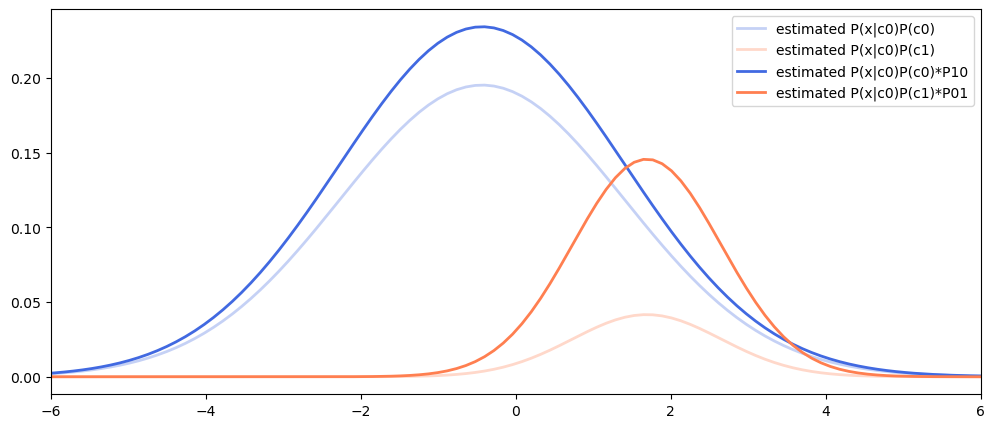

In [14]:
fig, axs = plt.subplots(1, figsize=((12,5)))
axs.plot(x, p0_proportional, 'k', linewidth=2, color='royalblue', alpha=0.3, label='estimated P(x|c0)P(c0)')
axs.plot(x, p1_proportional, 'k', linewidth=2, color='coral', alpha=0.3, label='estimated P(x|c0)P(c1)')
axs.plot(x, p0_proportional*P10, 'k', linewidth=2, color='royalblue', label='estimated P(x|c0)P(c0)*P10')
axs.plot(x, p1_proportional*P01, 'k', linewidth=2, color='coral', label='estimated P(x|c0)P(c1)*P01')
axs.set_xlim([-6, 6])
axs.legend()

The region which the $C_1$ curve is above the $C_0$ curve will result in the prediction of the $C_1$ class

### Classes reweight

The idea of class reweight is to take into account the asymmetry of cost errors directly curing the classifier training. Doing so, the outputted probabilities for each class we already embed the cost error information and could then be used to define a classification rule with a simple 0.5 threshold.

For some models (e.g. neural network classifiers), taking the cost into account during training can consist in adjusting the objective function. We still want out classifier to output:

\begin{equation*}
P(true \ C_1|x) \ \text{and} \ P(true \ C_0|x)
\end{equation*}

but this time it is trained such as to minimise the following cost function

\begin{equation*}
P(true \ C_1|x) \times P01 < P(true \ C_0|x) \times P10
\end{equation*}

For some other models (e.g. Bayes classifier), resampling methods can be used to bias the classes proportions such that to enter the cost error information inside the classes proportions. If we consider the costs $P01$ and $P10$ (such that $P01$ > $P10$), we can either:
- oversample the minority class by a factor $P01/P10$ (cardinality of the minority class should be multiplied by $P01/P10$)
- undersample the majority class by a factor $P10/P01$ (cardinality of the majority class should be multiplied by $P10/P01$)

The sklearn package has a function to compute class weights. Which can be passed into the models during training adjusting their training cost according to the class weights.

In [15]:
# Create the y column 45 (90%) for class C0 and and 5 (10%) for class C1
y = np.zeros(50)
y[-5:] = 1

In [16]:
y

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.])

Calculate the class weights:

In [17]:
compute_class_weight('balanced', np.array([0, 1]), y)

array([0.55555556, 5.        ])

Class weights are as follows:
- $C_0$ = 0.55
- $C_1$ = 5

Pass these values as P10 and P01 and plot the new distributions:

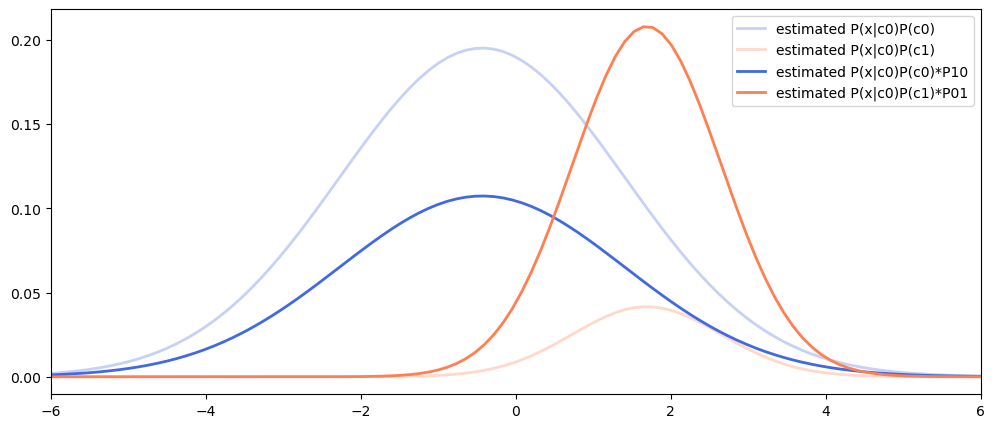

In [18]:
P10 = 0.55
P01 = 5
fig, axs = plt.subplots(1, figsize=((12,5)))
axs.plot(x, p0_proportional, 'k', linewidth=2, color='royalblue', alpha=0.3, label='estimated P(x|c0)P(c0)')
axs.plot(x, p1_proportional, 'k', linewidth=2, color='coral', alpha=0.3, label='estimated P(x|c0)P(c1)')
axs.plot(x, p0_proportional*P10, 'k', linewidth=2, color='royalblue', label='estimated P(x|c0)P(c0)*P10')
axs.plot(x, p1_proportional*P01, 'k', linewidth=2, color='coral', label='estimated P(x|c0)P(c1)*P01')
axs.set_xlim([-6, 6])
axs.legend()

Really increased the $C_1$ curve to be above the $C_0$ curve therefore increasing the likelihood of this class being selected.

# Takeaways

- Evaluation metrics must be chosen cautiously: We must use the metrics that gives us the best overview of how well our model is doing  with regards to our goals
- When dealing with imbalanced datasets, if classes are not well separable with the given variables and if our goal is to get the best possible accuracy, the best classifier can be a "naive" one that always answers the majority class
- Resampling methods can be used but have to thought carefully: they should not be used as a standalone solutions but have to be coupled with a rework of the problem to serve a specific goal
- Reworking the problem itself is often the best way to tackle an imbalanced classes problem: the classifier and the decision rule have to be set with respect to a well-chosen goal than can be, for example, minimising cost.
- Adding a new feature which enriches the dataset is a far better solution to resampling which has its own problems.
